In [1]:
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import cv2
from google.colab.patches import cv2_imshow

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os


from random import shuffle

from tensorflow import keras 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation ,TimeDistributed

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score


from keras.applications import  ResNet50
from keras.layers import Dense, GlobalAveragePooling2D,Flatten, Dropout, ZeroPadding3D, ConvLSTM2D, Reshape, BatchNormalization, Activation
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

import seaborn as sns

import random
import scipy

from google.colab import drive

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
sys.path.append('/content/drive/MyDrive/Neural Network 2023/Extra')

In [5]:
# Frame size  
IMG_SIZE = 256
BATCH_SIZE = 2
EPOCHS = 20

MAX_SEQ_LENGTH = 10
NUM_FEATURES = 2048 

# Number of frames per video
_images_per_file = 20

In [6]:
def label_video_names(in_dir):
    
    # list containing video names
    names = []
    # list containin video labels [1, 0] if it has violence and [0, 1] if not
    labels = []
    
    
    for current_dir, dir_names,file_names in os.walk(in_dir):
        
        for file_name in file_names:
            
            if file_name[0:2] == 'fi':
                labels.append(0)
                names.append(file_name)
            elif file_name[0:2] == 'no':
                labels.append(1)
                names.append(file_name)                  
            
    return names, labels

In [7]:
# First get the names and labels of the whole videos
in_dir = "./drive/MyDrive/Neural Network 2023/Extra/hockeyfights"
names, labels = label_video_names(in_dir)
names = np.array(names)
labels = np.array(labels)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(names, labels, test_size=0.2, random_state=42)

In [9]:
train_df = pd.DataFrame(data ={'video_name':X_train,
                               'tag':y_train},
                               columns = ('video_name' , 'tag'))

test_df = pd.DataFrame(data ={'video_name':X_test,
                              'tag':y_test},
                              columns = ('video_name' , 'tag'))

In [11]:
# X_train=[]
# X_test=[]
# y_train=[]
# y_test = []

In [12]:
print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

Total videos for training: 800
Total videos for testing: 200


In [13]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=20, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [14]:
def get_frames_diff(frames):
  images = []
  for i in range(10):
    index = ((i+1)*2)
    temp = frames[(index-2):index]
    frame_diff = cv2.absdiff(temp[0],temp[1])
    images.append(frame_diff)
  
  resul = np.array(images)
  return resul


In [15]:
def build_feature_extractor():
    feature_extractor = keras.applications.ResNet50(
        weights="imagenet",
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.resnet50.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

In [46]:
feature_extractor.summary()

Model: "feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 256, 256, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [16]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = np.array(labels[..., None])


    video_frames =[]

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        
        #calculate the difference of two executive frames
        frames = get_frames_diff(frames)
        video_frames.append(frames)
    
    return np.array(video_frames) ,labels



train_data, train_labels = prepare_all_videos(train_df, in_dir)
test_data, test_labels = prepare_all_videos(test_df, in_dir)

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Frame features in train set: (10, 256, 256, 3)
Frame masks in train set: (10, 256, 256, 3)


In [17]:
# train_df =[]
# test_df =[]

In [18]:
corner_keys = ["Center","Left_up","Left_down","Right_up","Right_down"]

In [19]:
def frame_loader(frames,figure_shape,to_norm = True):
    output_frames = []
    for frame in frames:
        image = frame

        # Scale
        figure = (image / 255.).astype(np.float32)
        # Normalize
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        figure = (figure - mean) / std
        output_frames.append(figure)
    return output_frames

In [20]:
def crop_img__remove_Dark(img,x_crop,y_crop,x,y,figure_size):
    x_start = x_crop
    x_end = x-x_crop
    y_start = y_crop
    y_end = y-y_crop
    return cv2.resize(img[y_start:y_end,x_start:x_end,:]
                      ,(figure_size,figure_size))

In [21]:
def crop_img(img,figure_shape,percentage=0.8,corner="Left_up"):
    if(corner == None):
        corner = random.choice(corner_keys)

    if corner not in corner_keys:
        raise ValueError(
            'Invalid corner method {} specified. Supported '
            'corners are {}'.format(
                corner,
                ", ".join(corner_keys)))

    resize = int(figure_shape*percentage)
    if(corner =="Left_up"):
        x_start = 0
        x_end = resize
        y_start = 0
        y_end = resize
    if (corner == "Right_down"):
        x_start = figure_shape-resize
        x_end = figure_shape
        y_start = figure_shape-resize
        y_end = figure_shape
    if(corner =="Right_up"):
        x_start = 0
        x_end = resize
        y_start = figure_shape-resize
        y_end = figure_shape
    if (corner == "Left_down"):
        x_start = figure_shape-resize
        x_end = figure_shape
        y_start = 0
        y_end = resize
    if (corner == "Center"):
        half = int(figure_shape*(1-percentage))
        x_start = half
        x_end = figure_shape-half
        y_start = half
        y_end = figure_shape-half

    img = cv2.resize(img[y_start:y_end,x_start:x_end, :],
                     (figure_shape, figure_shape)).astype(np.float32)
    return img

In [22]:
Debug_Print_AUG=False

def get_sequences(data_paths,labels,figure_shape,seq_length,classes=1, use_augmentation = False,use_crop=True,crop_x_y=None):
    X, y = [], []
    seq_len = 0
    for data_path, label in zip(data_paths,labels):
        frames = data_path
        x = frame_loader(frames, figure_shape)
        if(crop_x_y):
            x = [crop_img__remove_Dark(x_,crop_x_y[0],
                                       crop_x_y[1],x_.shape[0],
                                       x_.shape[1],figure_shape) for x_ in x]
        if use_augmentation:
            rand = np.random.random()
            corner=""
            if rand > 0.5:
                if(use_crop):
                    corner=random.choice(corner_keys)
                    x = [crop_img(x_,figure_shape,0.7,corner) for x_ in x]
                x = [frame.transpose(1, 0, 2) for frame in x]
                if(Debug_Print_AUG):
                    to_write = [list(a) for a in zip(frames, x)]
                    [cv2.imwrite(x_[0] + "_" + corner, x_[1] * 255) for x_ in to_write]

        x = [x[i] - x[i+1] for i in range(len(x)-1)]
        X.append(x)
        y.append(label)
    X = pad_sequences(X, maxlen=seq_length, padding='pre', truncating='pre')
    if classes > 1:
        x_ = to_categorical(x_,classes)
    return np.array(X), np.array(y)

In [23]:
def data_generator(data_paths,labels,batch_size,figure_shape,seq_length,use_aug,use_crop,crop_x_y,classes = 1):
    while True:
        indexes = np.arange(len(data_paths))
        np.random.shuffle(indexes)
        select_indexes = indexes[:batch_size]
        data_paths_batch = [data_paths[i] for i in select_indexes]
        labels_batch = [labels[i] for i in select_indexes]

        X, y = get_sequences(data_paths_batch,
                             labels_batch,
                             figure_shape,
                             seq_length,
                             classes,
                             use_augmentation = use_aug,
                             use_crop=use_crop,
                             crop_x_y=crop_x_y)

        yield X, y

In [24]:
def get_generators(train_path, valid_path, test_path,train_y, valid_y, test_y, fix_len, figure_size, classes=1, use_aug=False,
                   use_crop=True, crop_dark=True):
  
    if fix_len is not None:
        avg_length = fix_len
    crop_x_y = None
    if (crop_dark):
        crop_x_y = (11, 38)

    batch_size=2

    len_train, len_valid = len(train_path), len(valid_path)

    train_gen = data_generator(train_path, train_y, batch_size, figure_size, avg_length, use_aug=use_aug,
                                              use_crop=use_crop, crop_x_y=crop_x_y, classes=classes)
    validate_gen = data_generator(valid_path, valid_y, batch_size, figure_size, avg_length,
                                                 use_aug=False, use_crop=False, crop_x_y=crop_x_y, classes=classes)
    test_x, test_y = get_sequences(test_path, test_y, figure_size, avg_length, crop_x_y=crop_x_y,
                                                  classes=classes)

    return train_gen, validate_gen, test_x, test_y, avg_length, len_train, len_valid

In [25]:
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

In [36]:
last_fight = np.where(train_labels == 0)[0][-1]
last_no_fight = np.where(train_labels == 1)[0][-1]

print(last_fight)
print(last_no_fight)

639
636


In [43]:
len(train_data[last_fight])

10

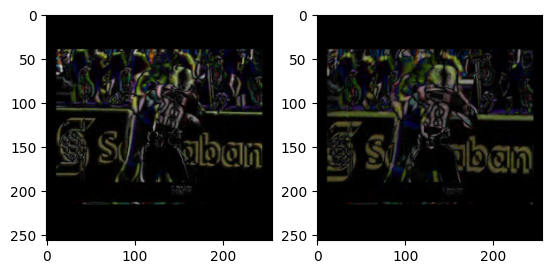

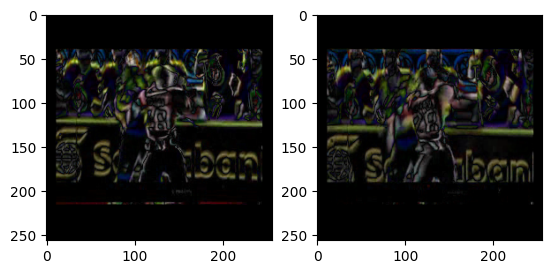

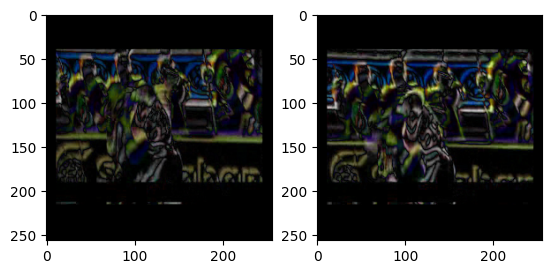

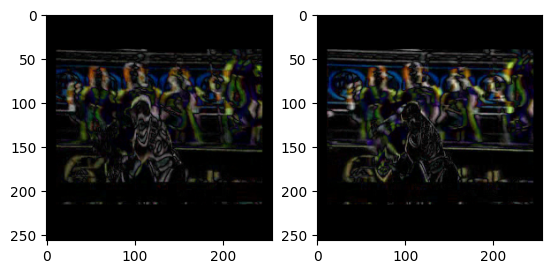

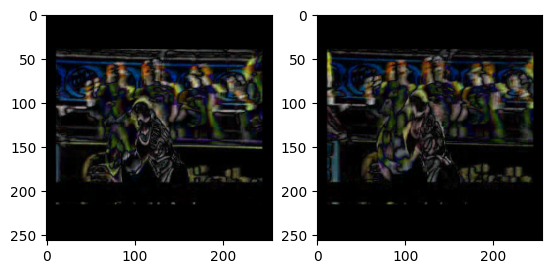

In [49]:
counter =0 
for i  in range(5):
  plt.figure()
  plt.subplot(121)
  plt.imshow(train_data[last_fight][counter])
  plt.subplot(122)
  plt.imshow(train_data[last_fight][counter+1])
  plt.show()
  counter +=2


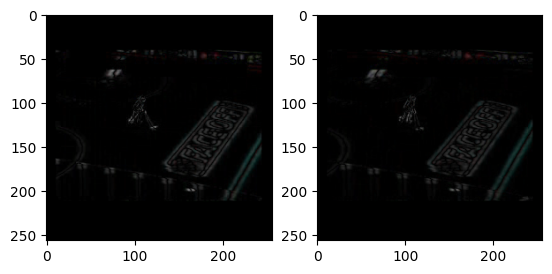

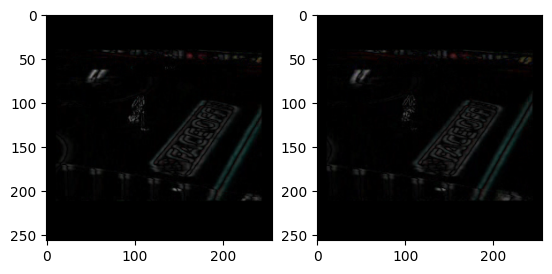

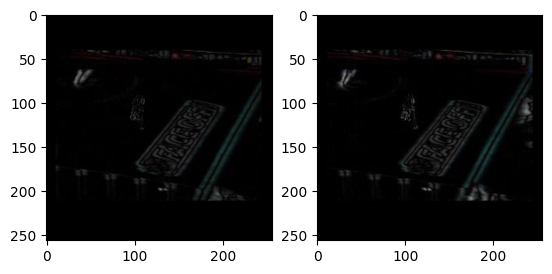

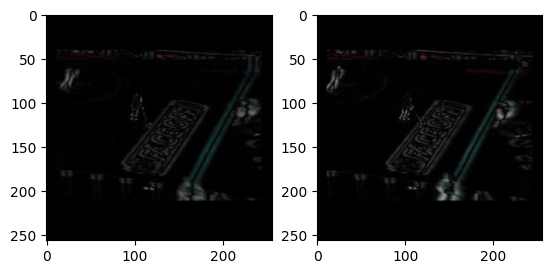

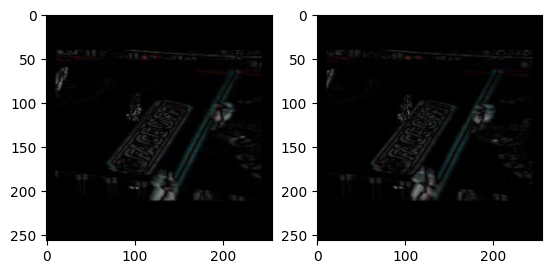

In [50]:
counter =0 
for i  in range(5):
  plt.figure()
  plt.subplot(121)
  plt.imshow(train_data[last_no_fight][counter])
  plt.subplot(122)
  plt.imshow(train_data[last_no_fight][counter+1])
  plt.show()
  counter +=2

In [26]:
use_aug=True
classes=1
batch_epoch_ratio = 0.5
patience_es=15
patience_lr=5

train_gen, validate_gen, test_x, test_y, seq_len, len_train, len_valid = get_generators(train_data,
                                                                                        val_data,test_data,
                                                                                        train_labels,val_labels,
                                                                                        test_labels, MAX_SEQ_LENGTH,
                                                                                        IMG_SIZE,
                                                                                        use_aug=use_aug,
                                                                                        use_crop=True,
                                                                                        crop_dark=True)

In [27]:
# Model structure

seq_len=10
size=256
dropout = 0.0

input_layer = Input(shape=(seq_len, size, size, 3))
ResNet50_base_model = ResNet50(weights='imagenet', include_top=False) 
cnn = TimeDistributed(ResNet50_base_model)(input_layer)

lstm= ConvLSTM2D(256, (3, 3), padding='same', return_sequences=False)(cnn)

#lstm = MaxPooling2D(pool_size=(2, 2))(lstm)
flat = Flatten()(lstm)

flat = BatchNormalization()(flat)
flat = Dropout(dropout)(flat)
linear = Dense(1000)(flat)

relu = Activation('relu')(linear)
linear = Dense(256)(relu)
linear = Dropout(dropout)(linear)
relu = Activation('relu')(linear)
linear = Dense(10)(relu)
linear = Dropout(dropout)(linear)
relu = Activation('relu')(linear)

activation = 'sigmoid'
loss_func = 'binary_crossentropy'
classes=1
dropout = 0.0

predictions = Dense(classes,  activation=activation)(relu)

model = Model(inputs=input_layer, outputs=predictions)

for layer in ResNet50_base_model.layers:
    layer.trainable = False

model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10, 256, 256, 3)  0         
                             ]                                   
                                                                 
 time_distributed (TimeDistr  (None, 10, 8, 8, 2048)   23587712  
 ibuted)                                                         
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 8, 8, 256)         21234688  
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                             

In [28]:
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        self.test_loss = []
        self.test_acc = []

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, batch_size=5, verbose=0)
        self.test_loss.append(loss)
        self.test_acc.append(acc)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

test_history = TestCallback((test_x, test_y))

In [29]:
history = model.fit_generator(
        steps_per_epoch=int(float(len_train) / float(BATCH_SIZE * batch_epoch_ratio)),
        generator=train_gen,
        epochs=EPOCHS,
        validation_data=validate_gen,
        validation_steps=int(float(len_valid) / float(BATCH_SIZE)),
        callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.001, patience=patience_es, ),
                   ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=patience_lr, min_lr=1e-8, verbose=1),
                   test_history
                   ]
    )

<ipython-input-29-5bde5987e9bf>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
640/640 [==============================] - ETA: 0s - loss: 0.6957 - accuracy: 0.6375
Testing loss: 0.6748172044754028, acc: 0.7950000166893005

640/640 [==============================] - 245s 355ms/step - loss: 0.6957 - accuracy: 0.6375 - val_loss: 0.6053 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 2/20
640/640 [==============================] - ETA: 0s - loss: 0.6271 - accuracy: 0.7008
Testing loss: 0.9043184518814087, acc: 0.7699999809265137

640/640 [==============================] - 223s 349ms/step - loss: 0.6271 - accuracy: 0.7008 - val_loss: 0.6846 - val_accuracy: 0.7750 - lr: 0.0010
Epoch 3/20
640/640 [==============================] - ETA: 0s - loss: 0.6011 - accuracy: 0.7031
Testing loss: 4.273901462554932, acc: 0.5

640/640 [==============================] - 214s 334ms/step - loss: 0.6011 - accuracy: 0.7031 - val_loss: 3.9226 - val_accuracy: 0.5750 - lr: 0.0010
Epoch 4/20
640/640 [==============================] - ETA: 0s - loss: 0.5839 - accuracy: 0.7250
Testing los

In [ ]:
history.history

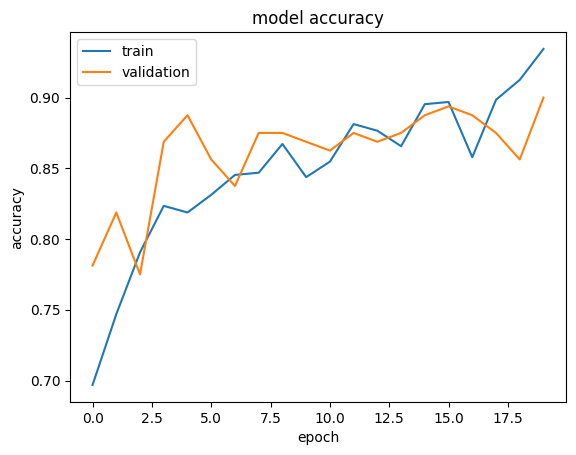

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

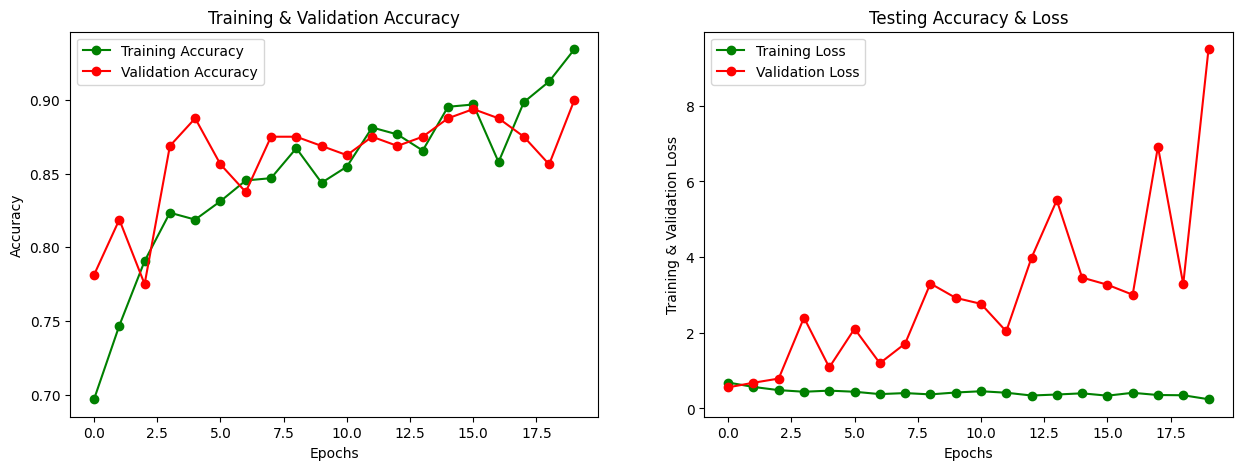

In [ ]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(15,5)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
predictions = model.predict(test_data)
predictions = predictions.reshape(1,-1)[0]
predictions =np.where(predictions < 0.5, 0, 1)

7/7 [==============================] - 16s 2s/step


<Axes: >

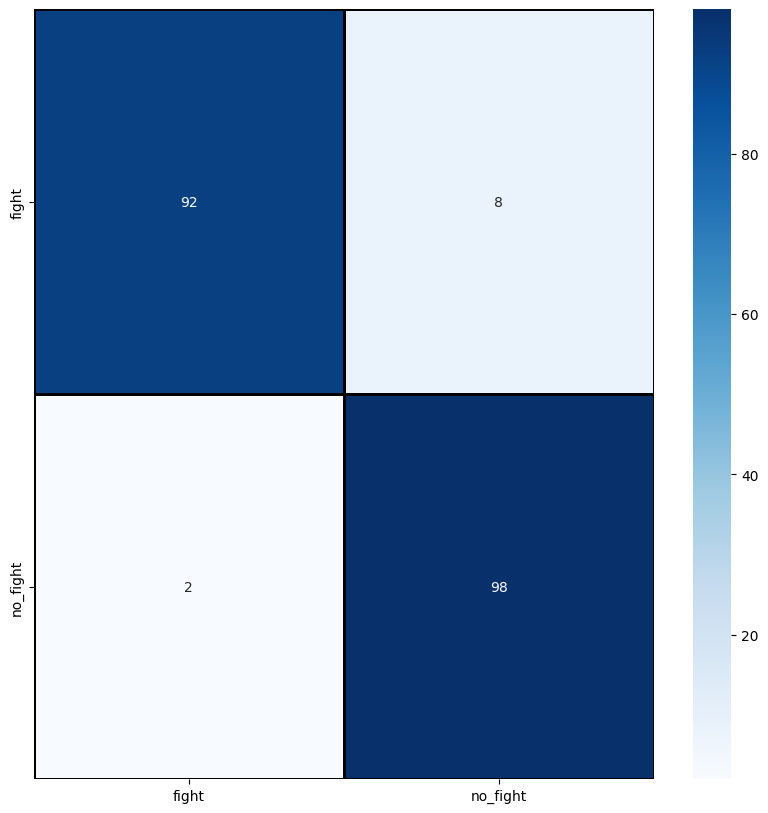

In [ ]:
LABEL_NAMES = ['fight' , 'no_fight']
cm = confusion_matrix(test_labels,predictions)

cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = LABEL_NAMES,yticklabels = LABEL_NAMES)

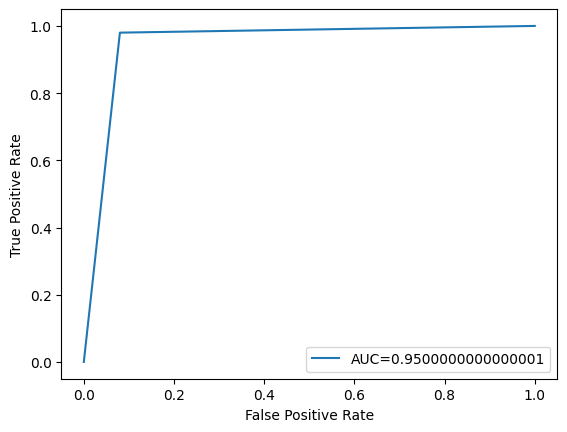

In [ ]:
fpr, tpr, _ = roc_curve(test_labels,  predictions)
auc = roc_auc_score(test_labels, predictions)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
print(classification_report(test_labels,  predictions))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95       100
           1       0.92      0.98      0.95       100

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200

